# Gift Recommender Engine: Twitter Data Analysis

Before I test on real tweet data extracted using Twitter's API, I want to develop and evaluate a tweet processing approach. To do this, I will use a dataset found in [Kaggle](https://www.kaggle.com/kazanova/sentiment140) that contains over 1.6 million tweets labelled as negative or positive. I will test different sentiment analysis and topic modelling approaches on this dataset, while also devising a strategy to make my classifier more "compatible" with tweets and further evaluate my classifier.

## Import Libraries

In [328]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import nltk 
import string
import spacy

warnings.filterwarnings('ignore')
%matplotlib inline

sns.set_style('ticks')

In [329]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from spacytextblob.spacytextblob import SpacyTextBlob

In [141]:
encoding = "ISO-8859-1"
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('datasets/training.1600000.processed.noemoticon.csv', encoding=encoding, names=columns) 

In [142]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [143]:
print(df.shape)
df.isna().sum()

(1600000, 6)


target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

## Exploratory Data Analysis

<b> How many positive and negative tweets are in the dataset? </b>

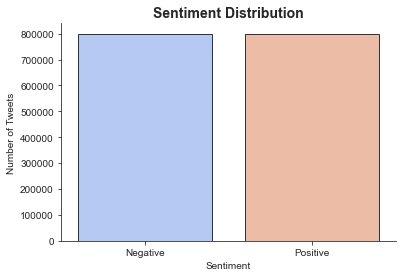

In [144]:
df_size = df.groupby('target').size().reset_index().rename(columns={0:'size'})
df_size['target'] = df_size['target'].apply(lambda x: 'Negative' if x == 0 else 'Positive')

sns.barplot(x=df_size['target'], y=df_size['size'], edgecolor='.2', palette='coolwarm')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
sns.despine()

<b> Are there any duplicated tweets? How many unique users are there? </b>

In [145]:
id_size = df.groupby('ids').size().reset_index().rename(columns={0:'size'})

In [146]:
duplicated_ids = id_size[id_size['size'] == 2]['ids'].to_list()
duplicated_df = df[df.ids.isin(duplicated_ids)][['ids', 'target', 'text']].sort_values('ids')
duplicated_df.head(10)

,ids,target,text
213,1467863684,0,Awwh babs... you look so sad underneith that s...
800261,1467863684,4,Awwh babs... you look so sad underneith that s...
275,1467880442,0,Haven't tweeted nearly all day Posted my webs...
800300,1467880442,4,Haven't tweeted nearly all day Posted my webs...
989,1468053611,0,@hellobebe I also send some updates in plurk b...
801280,1468053611,4,@hellobebe I also send some updates in plurk b...
1177,1468100580,0,good night swetdreamss to everyonee and jare...
801573,1468100580,4,good night swetdreamss to everyonee and jare...
1254,1468115720,0,@ientje89 aw i'm fine too thanks! yeah i miss ...
801650,1468115720,4,@ientje89 aw i'm fine too thanks! yeah i miss ...


It appears that the tweets belonging to the duplicated ids are classified as both positive and negative. This may mean that these tweets are neutral, but because this is such a small subset of the entire dataset and to avoid confusion, I will drop these tweets.

In [147]:
df = df[~df.ids.isin(duplicated_ids)]
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [148]:
num_users = df.groupby('user').size().reset_index().rename(columns={0: 'num_tweets'})
print('Total number of users: ', len(num_users))
print('Average number of tweets per user: ', round(num_users['num_tweets'].mean()))
num_users['num_tweets'].describe().reset_index().rename(columns={'index': 'metric', 'num_tweets': 'result'})

Total number of users:  659502
Average number of tweets per user:  2


,metric,result
0,count,659502.000000
1,mean,2.420963
2,std,4.697115
3,min,1.000000
4,25%,1.000000
5,50%,1.000000
6,75%,2.000000
7,max,549.000000


In [149]:
print("Number of users who have Tweeted more than 50 times: ", len(num_users[num_users.num_tweets >= 50]))

Number of users who have Tweeted more than 50 times:  919


Interesting; there are close to 1,600,000 unique tweets in this dataset but there are only 659,502 users. There are 919 users who have tweeted more than 50 times. I think I will extract 150 users who has tweeted more than 50 times and try to determine their interest from their tweets using my topic classifer which can be used as an evaluation tool.

In [150]:
many_tweets = num_users[num_users.num_tweets >= 50]['user'].to_list()
random.shuffle(many_tweets)
random_users = many_tweets[:150]

In [151]:
validate_df = df[df.user.isin(random_users)]
df = df[~df.user.isin(random_users)]

In [500]:
df.to_csv('datasets/kaggle-tweets.csv')

In [155]:
validate_df.to_csv('datasets/kaggle-tweets-users150.csv')

<b> What is the approximate length of each tweet? </b>

In [162]:
print('Average Tweet Length: {} words'.format(round(df.text.apply(lambda x: len(x.split())).mean())))

Average Tweet Length: 13 words


<b> Final checks! </b>

Let's check if the distribution of our dataset is still balanced!

In [157]:
df.groupby('target').size()

target
0    793821
4    791115
dtype: int64

It's still balanced! We can start to do some data cleaning before we experiment with sentiment analysis and topic modelling approaches.

## Data Cleaning Functions

In [245]:
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

punctuations = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    text = text.split() #split into list
    text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    text = [s.lower() for s in text] #convert every character into lowercase
    text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    return text

## Sentiment Analysis

In [331]:
sa_df = df[['target', 'text']]

### Vader Sentiment Analysis - Before and After Preprocessing

In [332]:
analyzer = SentimentIntensityAnalyzer()
sa_df['vader_results'] = sa_df['text'].apply(lambda x: analyzer.polarity_scores(x))

In [501]:
sa_df['vader_results']

0          {'neg': 0.117, 'neu': 0.768, 'pos': 0.114, 'co...
1          {'neg': 0.291, 'neu': 0.709, 'pos': 0.0, 'comp...
2          {'neg': 0.0, 'neu': 0.842, 'pos': 0.158, 'comp...
3          {'neg': 0.321, 'neu': 0.5, 'pos': 0.179, 'comp...
4          {'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp...
                                 ...                        
1599995    {'neg': 0.138, 'neu': 0.503, 'pos': 0.358, 'co...
1599996    {'neg': 0.0, 'neu': 0.776, 'pos': 0.224, 'comp...
1599997    {'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound...
1599998    {'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'comp...
1599999    {'neg': 0.0, 'neu': 0.519, 'pos': 0.481, 'comp...
Name: vader_results, Length: 1584936, dtype: object

## Topic Modelling